In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import spacy

### Import

In [2]:
df=pd.read_csv("Verb_Subject_Object.csv")
df.head()

,Wikipedia movie ID,Sentence,Verb,Subject,Object
0,31186339,1,consist,"[The, nation, of, Panem]",NaN
1,31186339,2,provide,"[each, district]","[a, boy, and, girl, ]"
2,31186339,2,select,"[by, lottery, , for, the, annual, Hunger, Games]",NaN
3,31186339,3,fight,"[The, tributes]",NaN
4,31186339,3,reward,NaN,"[the, sole, survivor]"


In [3]:
verbs=df["Verb"]
print(verbs)

0       consist
1       provide
2        select
3         fight
4        reward
         ...   
123    proclaim
124        warn
125        make
126        lock
127    consider
Name: Verb, Length: 128, dtype: object


# Word embeddings

### Word2vec

In [4]:
# Load spaCy model (you may need to install it first: pip install spacy)
nlp = spacy.load("en_core_web_md")

# Get embeddings for each verb
verb_embeddings = [nlp(verb).vector for verb in verbs]

In [5]:
# Calculate cosine similarity matrix
similarity_matrix = np.dot(verb_embeddings, np.transpose(verb_embeddings))

### Clustering with Word2Vec

In [14]:
# Apply K-means clustering
k = 3  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(verb_embeddings)

# Print the clusters
for cluster_id in range(k):
    cluster_verbs = [verb for i, verb in enumerate(verbs) if clusters[i] == cluster_id]
    print(f"\nCluster {cluster_id + 1}: {cluster_verbs}")

/Users/davide/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Cluster 1: ['take', 'give', 'take', 'warn', 'mean', 'say', 'kill', 'ignore', 'run', 'call', 'find', 'hide', 'draw', 'hang', 'drop', 'sleep', 'kill', 'warn', 'run', 'draw', 'kill', 'run', 'hear', 'call', 'find', 'throw', 'shoot', 'die', 'turn', 'make', 'hear', 'find', 'get', 'go', 'kill', 'kill', 'keep', 'die', 'eat', 'steal', 'know', 'kill', 'flee', 'shoot', 'tell', 'shoot', 'give', 'warn', 'make']

Cluster 2: ['consist', 'provide', 'select', 'fight', 'reward', 'choose', 'starve', 'accompany', 'train', 'reveal', 'believe', 'gain', 'provide', 'discover', 'begin', 'survive', 'strew', 'form', 'corner', 'scatter', 'care', 'recover', 'gather', 'destroy', 'set', 'plant', 'assign', 'guard', 'trap', 'release', 'dodge', 'cause', 'stab', 'comfort', 'gather', 'arrange', 'televise', 'spark', 'summon', 'express', 'present', 'cross', 'convince', 'avoid', 'incite', 'announce', 'search', 'portray', 'gain', 'proclaim', 'need', 'provide', 'beg', 'risk', 'promise', 'fall', 'head', 'ambush', 'pin', 'over

### Using a transformers

In [7]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

/Users/davide/anaconda3/envs/ada/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [9]:
# Load model from HuggingFace Hub

# use "sentence-transformers/all-MiniLM-L6-v2" model for faster embeddings
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

In [10]:
# Tokenize sentences
encoded_input = tokenizer(verbs.tolist(), padding=True, truncation=True, return_tensors='pt')

In [15]:
# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

### Clustering with transformers

In [16]:
# Apply K-means clustering
k = 3  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(sentence_embeddings)

# Print the clusters
for cluster_id in range(k):
    cluster_verbs = [verb for i, verb in enumerate(verbs) if clusters[i] == cluster_id]
    print(f"\nCluster {cluster_id + 1}: {cluster_verbs}")


Cluster 1: ['strew', 'corner', 'scatter', 'set', 'assign', 'guard', 'trap', 'stab', 'arrange', 'spark', 'express', 'cross', 'incite', 'ambush', 'pin', 'torment', 'spare', 'speed', 'force', 'encounter', 'wound', 'spare', 'lock']

Cluster 2: ['fight', 'starve', 'train', 'win', 'mean', 'kill', 'survive', 'ignore', 'run', 'call', 'hide', 'draw', 'hang', 'drop', 'sleep', 'kill', 'run', 'recover', 'draw', 'destroy', 'kill', 'run', 'call', 'throw', 'dodge', 'shoot', 'die', 'turn', 'avoid', 'win', 'go', 'fall', 'head', 'kill', 'kill', 'work', 'die', 'eat', 'kill', 'flee', 'hurl', 'shoot', 'shoot']

Cluster 3: ['consist', 'provide', 'select', 'reward', 'choose', 'take', 'give', 'take', 'accompany', 'warn', 'reveal', 'believe', 'gain', 'provide', 'discover', 'say', 'begin', 'form', 'find', 'warn', 'care', 'gather', 'plant', 'hear', 'find', 'release', 'cause', 'comfort', 'gather', 'televise', 'summon', 'present', 'convince', 'make', 'announce', 'hear', 'search', 'find', 'portray', 'gain', 'procl

/Users/davide/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Sentiment analysis

In [17]:
from transformers import pipeline
import torch

In [18]:
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)
result=classifier("I love this!")


/Users/davide/anaconda3/envs/ada/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [19]:
print(result[0][1]['score'])

0.0016119960928335786


In [20]:
result[0][1]['score']

0.0016119960928335786

In [25]:
# Create an empty DataFrame to store the results
columns = ['Verb', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
df_results = pd.DataFrame(columns=columns)

# Iterate through each verb and classify its emotion
for verb in verbs:
    # Classify emotion for the verb
    emotion_scores = classifier(verb)[0]
    
    # Create a dictionary with the results
    result_dict = {'Verb': verb}
    result_dict.update({emotion['label']: emotion['score'] for emotion in emotion_scores})
    # Append the results to the DataFrame
    df_results.loc[len(df_results)] = result_dict

# Display the final DataFrame
df_results.head()

,Verb,anger,disgust,fear,joy,neutral,sadness,surprise
0,consist,0.262421,0.065197,0.014777,0.007290,0.562595,0.060437,0.027282
1,provide,0.017003,0.002666,0.003732,0.057009,0.878940,0.011416,0.029235
2,select,0.022603,0.012375,0.016674,0.006748,0.883018,0.016742,0.041840
3,fight,0.367764,0.026259,0.149761,0.025016,0.368842,0.033233,0.029126
4,reward,0.153497,0.106684,0.011631,0.015223,0.585224,0.057922,0.069819


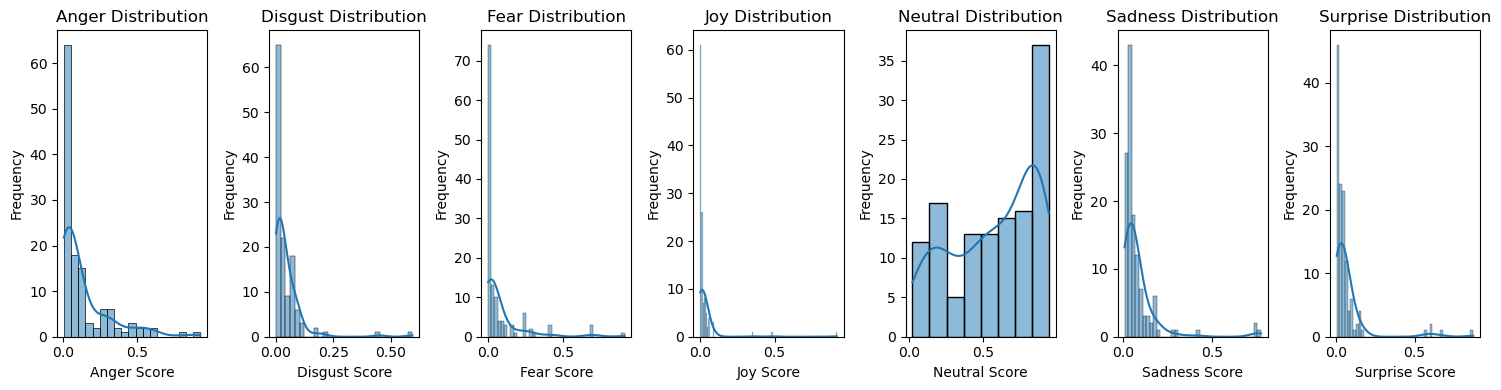

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_results is your DataFrame
columns_to_plot = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(15, 4))

# Plot KDE for each column
for i, column in enumerate(columns_to_plot):
    sns.histplot(df_results[column], kde=True, ax=axes[i])
    axes[i].set_title(f'{column.capitalize()} Distribution')
    axes[i].set_xlabel(f'{column.capitalize()} Score')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### Clustering with sentiment analysis

/Users/davide/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/davide/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


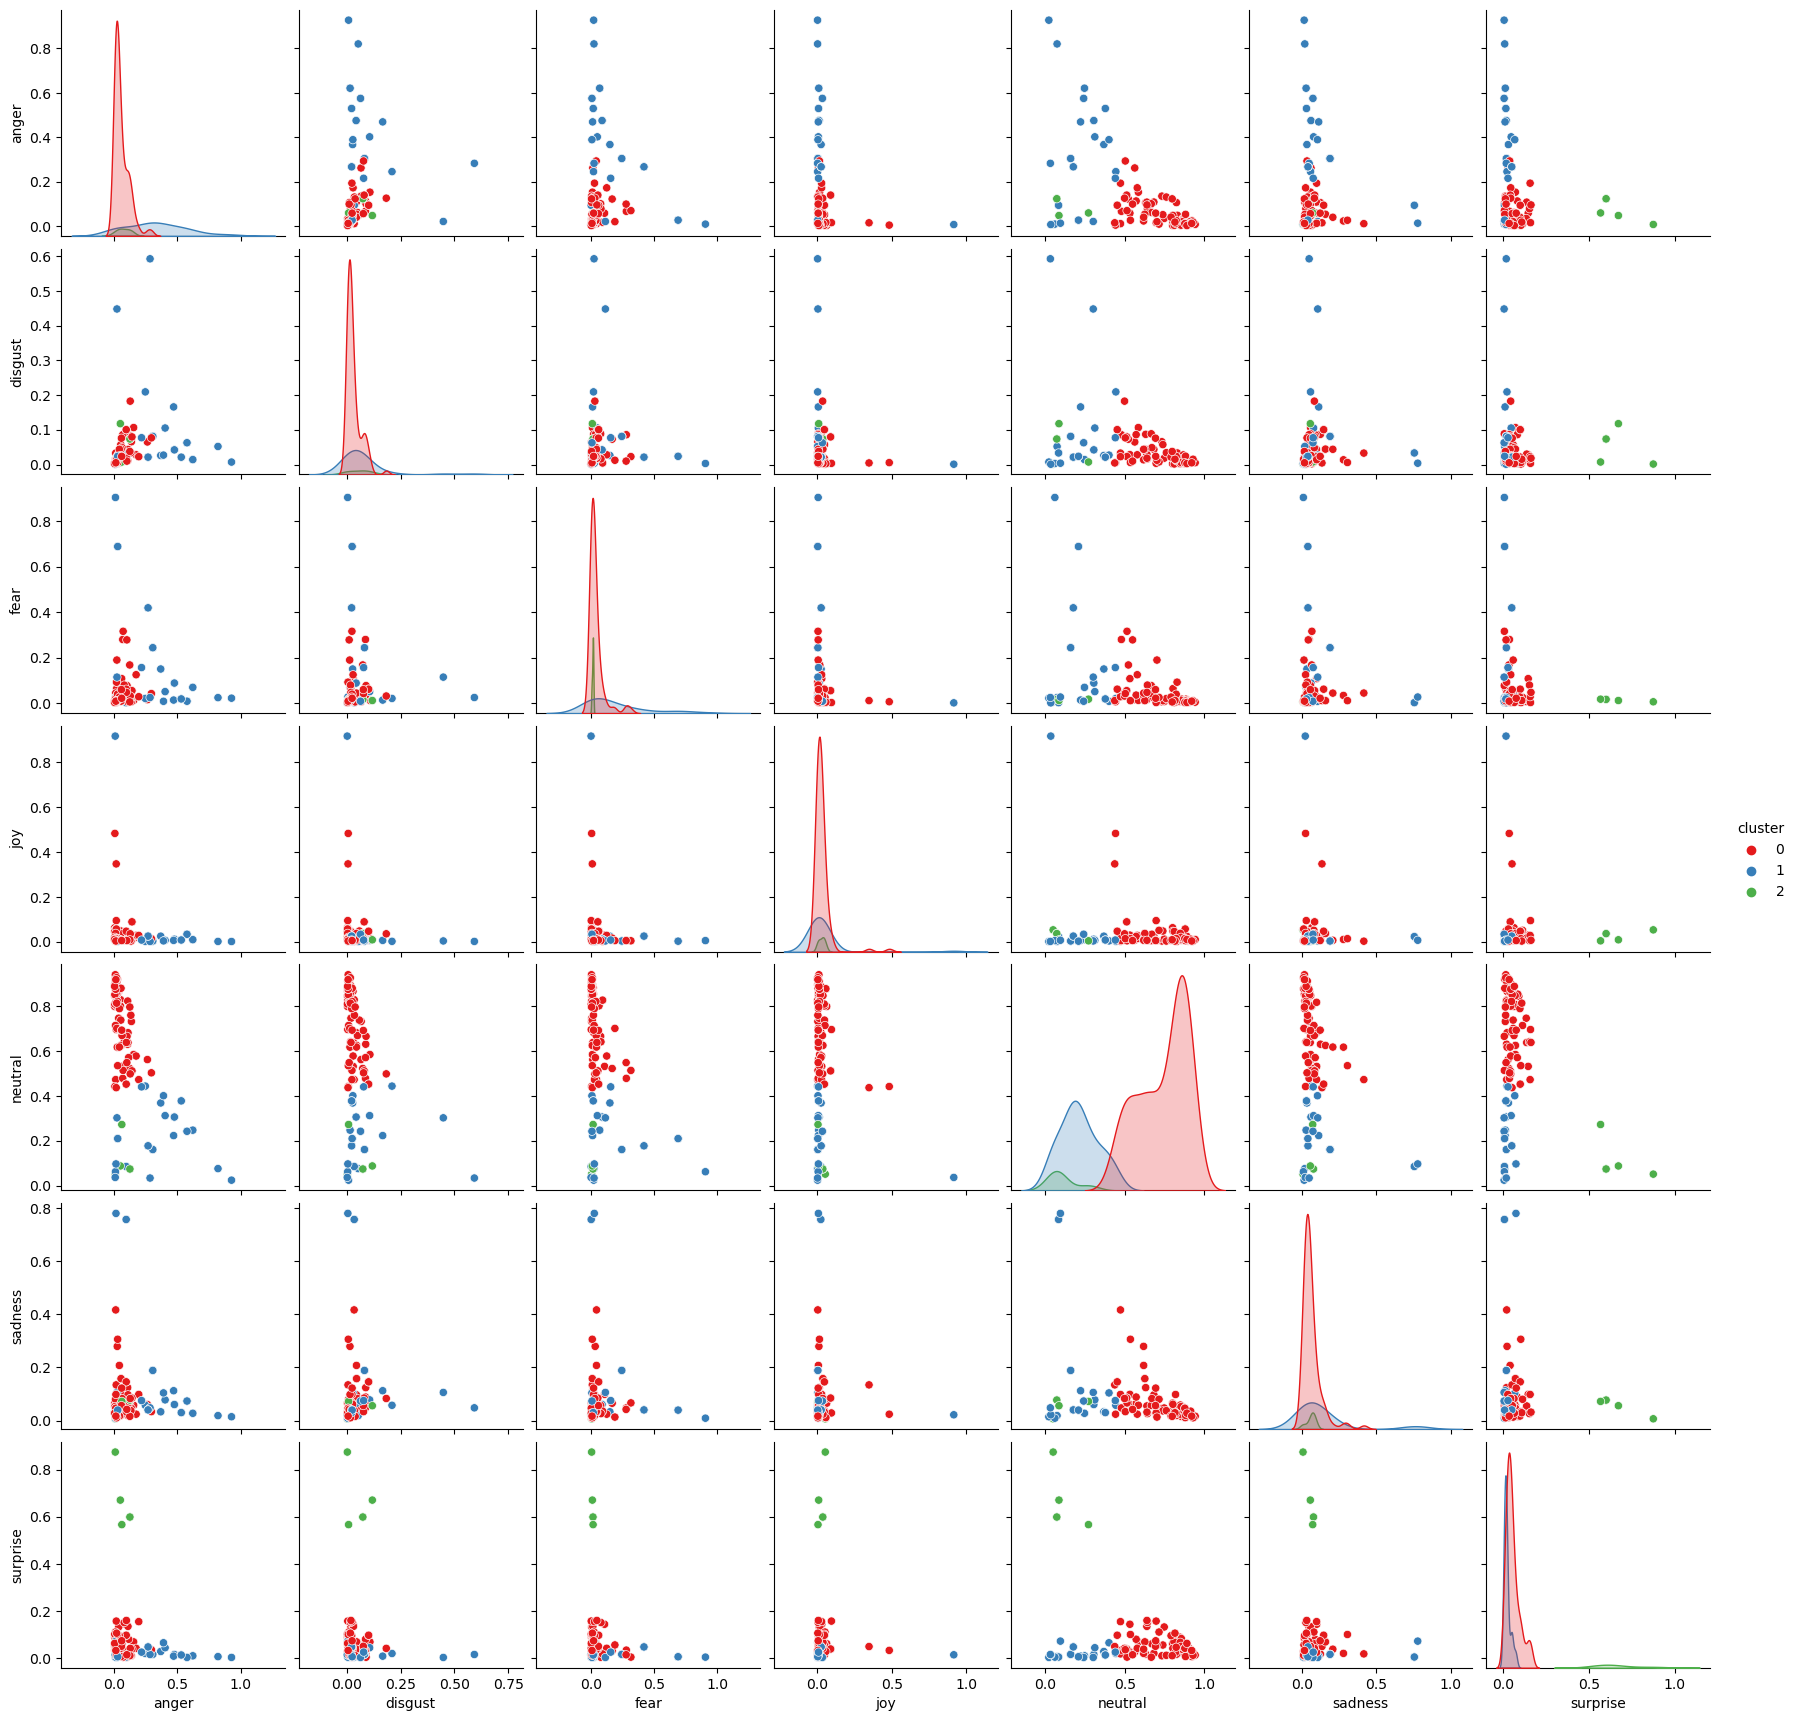

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select columns for clustering
columns_for_clustering = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
data_for_clustering = df_results[columns_for_clustering]

# Choose the number of clusters (K)
k = 3

# Apply K-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
df_results['cluster'] = kmeans.fit_predict(data_for_clustering)

# Visualize the clusters
sns.pairplot(df_results, hue='cluster', vars=columns_for_clustering, diag_kind='kde', palette='Set1')
plt.show()


In [28]:
# Print the verbs for each cluster
for cluster_id in range(k):
    cluster_verbs = df_results[df_results['cluster'] == cluster_id]['Verb'].tolist()
    print(f"\nCluster {cluster_id + 1} Verbs: {', '.join(cluster_verbs)}")



Cluster 1 Verbs: consist, provide, select, reward, choose, starve, accompany, train, win, reveal, gain, provide, discover, say, begin, survive, ignore, run, strew, call, form, find, corner, hide, hang, drop, sleep, scatter, run, care, recover, set, plant, assign, guard, run, call, find, trap, release, dodge, die, televise, spark, summon, express, turn, present, cross, convince, make, avoid, incite, announce, win, search, find, portray, gain, need, provide, get, promise, go, head, ambush, pin, torment, spare, work, keep, die, eat, steal, know, change, unleash, speed, force, encounter, hurl, spare, allow, revoke, tell, commit, make, lock

Cluster 2 Verbs: fight, take, give, take, warn, mean, kill, draw, kill, warn, gather, draw, destroy, kill, throw, cause, stab, shoot, comfort, gather, arrange, proclaim, risk, fall, kill, kill, kill, flee, wound, shoot, shoot, give, proclaim, warn, consider

Cluster 3 Verbs: believe, hear, hear, beg, overhear
